<a href="https://colab.research.google.com/github/blackJJW/DL/blob/main/self_study_DL/chapter9_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09-3 LSTM과 GRU 셀

## LSTM 구조

- Long Short-Term Memory
- 단기 기억을 오래 기억하기 위해 고안
- 입력과 가중치를 곱하고 절편을 더해 활성화 함수를 통과시키는 구조를 여러 개 가지고 있음
  - 이런 계산 결과는 다음 타임스텝에 재사용됨

- 은닉상태를 만드는 방법
  - 입력과 이전 타임스텝의 은닉 상태를 가중치에 곱한 후 활성화 함수를 통과시켜 다음 은닉 상태를 생성
    - 이때 기본 순환층과는 달리 시그모이드 활성화 함수를 사용
    - tanh 활성화 함수를 통과한 어떤 값과 곱해져서 은닉 상태를 만듦

- LSTM에는 순환되는 상태가 2개
  - 은닉 상태
  - 셀 상태(cell state) : 은닉 상태와 달리 다음 층으로 전달되지 않고 LSTM 셀에서 순환만 되는 값

- 셀 상태 계산
  1. 입력과 은닉 상태를 또 다른 가중치 $w_{i}$에 곱한 다음 시그모이드 함수를 통과
  2. 이전 타입스텝의 셀 사태와 곱하여 새로운 셀 상태를 생성
    - 이 셀 상태가 tanh 함수를 통과하여 새로운 은닉 상태를 만드는 데 기여

- LSTM은 작은 셀을 여러 개 포함하고 있는 큰 셀과 같음
- 중요한 것은 입력과 은닉 상태에 곱해지는 가중치 $w_{o}$와 $w_{f}$가 다르다는 점
  - 이 두 작은 셀은 각기 다른 기능을 위해 훈련됨

- 여기에 2개의 작은 셀이 더 추가되어 셀 상태를 만드는 데 기여\
  - LSTM은 총 4개의 셀이 있음
- 입력과 은닉 상태를 각기 다른 가중체에 곱한 다음, 하나는 시그모이드 함수를 통과시키고 다른 하나는 tanh 함수를 통과시킴
- 두 결과를 곱한 후 이전 셀 상태와 더함
  - 이 결과가 최종적인 다음 셀 상태가 됨


- 삭제 게이트, 입력 게이트, 출력 게이트
  - 삭제 게이트 : 셀 상태에 있는 정보를 제거하는 역할
  - 입력 게이트 : 새로운 정보를 셀 상태에 추가
  - 출력 게이트 : 이 게이트를 통해 셀 상태가 다음 은닉 상태로 출력

## LSTM 신경망 훈력

In [9]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

- 그 다음 케라스의 pad_sequences() 함수로 각 샘플의 길이를 100에 맞추고 부족할 때는 패딩을 추가

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

- LSTM 셀을 상요한 순환층을 생성

In [11]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_2 (LSTM)               (None, 8)                 800       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


- SimpleRNN 클래스의 모델 파라미터의 개수는 200개
- LSTM 셀에는 작은 셀이 4개 있으므로 정확히 4배가 늘어 모델 파라미터 개수는 800개가 됨

- 배치 크기 = 64
- 에포크 회수 = 100

In [13]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss = 'binary_crossentropy',
              metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5',
                                                 save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 13s 36ms/step - loss: 0.6926 - accuracy: 0.5258 - val_loss: 0.6917 - val_accuracy: 0.5680
Epoch 2/100
313/313 [==============================] - 11s 34ms/step - loss: 0.6904 - accuracy: 0.5907 - val_loss: 0.6886 - val_accuracy: 0.6204
Epoch 3/100
313/313 [==============================] - 11s 34ms/step - loss: 0.6845 - accuracy: 0.6497 - val_loss: 0.6792 - val_accuracy: 0.6664
Epoch 4/100
313/313 [==============================] - 11s 36ms/step - loss: 0.6555 - accuracy: 0.7054 - val_loss: 0.6158 - val_accuracy: 0.7126
Epoch 5/100
313/313 [==============================] - 12s 39ms/step - loss: 0.5900 - accuracy: 0.7181 - val_loss: 0.5802 - val_accuracy: 0.7160
Epoch 6/100
313/313 [==============================] - 11s 37ms/step - loss: 0.5650 - accuracy: 0.7347 - val_loss: 0.5579 - val_accuracy: 0.7402
Epoch 7/100
313/313 [==============================] - 11s 35ms/step - loss: 0.5449 - accuracy: 0.7499 - val_loss: 0.5432 - val_ac

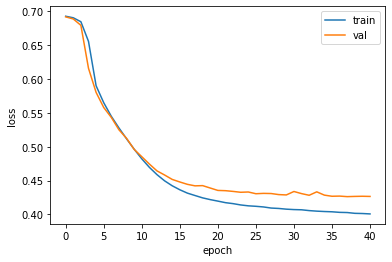

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 기본 순환층보다 LSTM이 과대적합을 억제하면서 훈련을 잘 수행
- 하지만 경우에 따라서는 과대적합을 더 강하게 제어할 필요가 있음

## 순환층에 드롭아웃 적용하기

- 완전 연결 실졍망과 합성곱 신경망에서는 Dropput 클래스를 사용해 드롭아웃을 적용
  - 드롭아웃은 은닉층에 있는 뉴런의 출력을 랜덤하게 꺼서 과대적합을 막는 기법
  - 이를 통해 모델이 훈련 세트에 너무 과대 적합된는 것을 막음
- 순환층은 자체적으로 드롭아웃 기능을 제공
- SimpleRNN과 LSTM 클래스 모두 dropout 매개변수와 recurrnet_dropout 매개변수를 가지고 있음
  

- dropout 매개변수는 셀의 입력에 드롭아웃을 적용하고 recurrent_dropout은 순환되는 은닉 상태에 드롭아웃을 적용
- 기술적인 문제로 인해 recurrent_dropout을 사용하면 GPU를 사용하여 모델을 훈련하지 못함
  - 이 때문에 모델의 훈련 속도가 크게 느려짐

- LSTM 클래스에 dropout 매개변수를 0.3으로 지정하여 30%의 입력을 드롭아웃

In [15]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [16]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss = 'binary_crossentropy',
              metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.h5',
                                                 save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 14s 37ms/step - loss: 0.6925 - accuracy: 0.5213 - val_loss: 0.6918 - val_accuracy: 0.5640
Epoch 2/100
313/313 [==============================] - 11s 36ms/step - loss: 0.6903 - accuracy: 0.5796 - val_loss: 0.6890 - val_accuracy: 0.6126
Epoch 3/100
313/313 [==============================] - 11s 36ms/step - loss: 0.6858 - accuracy: 0.6264 - val_loss: 0.6829 - val_accuracy: 0.6426
Epoch 4/100
313/313 [==============================] - 11s 36ms/step - loss: 0.6750 - accuracy: 0.6647 - val_loss: 0.6645 - val_accuracy: 0.6822
Epoch 5/100
313/313 [==============================] - 11s 36ms/step - loss: 0.6329 - accuracy: 0.6978 - val_loss: 0.5980 - val_accuracy: 0.7220
Epoch 6/100
313/313 [==============================] - 11s 36ms/step - loss: 0.5804 - accuracy: 0.7309 - val_loss: 0.5634 - val_accuracy: 0.7380
Epoch 7/100
313/313 [==============================] - 11s 35ms/step - loss: 0.5560 - accuracy: 0.7448 - val_loss: 0.5456 - val_ac

- 검증 손실이 약간 향상

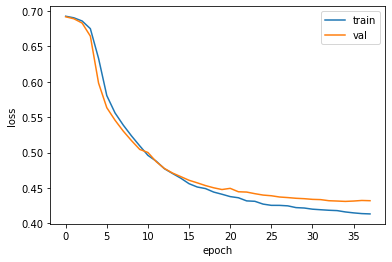

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- LSTM 층에 적용한 드롭아웃이 효과를 발휘
- 훈련 손실과 검증 손실 간의 차이가 좁혀진 것을 확인

## 2개의 층을 연결하기

- 순환층을 연결할 때는 한 가지 주의할 점이 존재
- 순환층의 은닉 상태는 샘플의 마지막 타임스탭에 대한 은닉 상태만 다음 층으로 전달
- 하지만 순환층을 쌓게 되면 모든 순환층에 순차 데이터가 필요
  - 앞쪽의 순환층이 모든 타임스텝에 대한 은닉 상태를 출력해야함
- 오직 마지막 순환층만 마지막 타임스텝의 은닉 상태를 출력해야함

- 케라스의 순환층에서 모든 타입스텝의 은닉 상태를 출력하려면 마지막을 제외한 다른 모든 순환층에서 return_sequences 매개변수를 True로 지정하면 됨

In [18]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500, 16, input_length=100))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

- 2개의 LSTM 층을 쌓았고 모두 드롭아웃을 0.3으로 지정
- 첫 번째 LSTM 클래스에는 return_sequences 매개변수를 True로 지정한 것을 확인

In [19]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_4 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_5 (LSTM)               (None, 8)                 544       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


- 첫 번째 LSTM 층이 모든 타임스텝(100개)의 은닉 상태를 출력하기 때문에 출력 크기가 (None, 100, 8)로 표시
- 두 번째 LSTM 층의 출력 크기는 마지막 타임스텝의 은닉 상태만 출력하기 때문에 (None, 8)

In [20]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss = 'binary_crossentropy',
              metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.h5',
                                                 save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model3.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 26s 71ms/step - loss: 0.6920 - accuracy: 0.5326 - val_loss: 0.6902 - val_accuracy: 0.5734
Epoch 2/100
313/313 [==============================] - 22s 70ms/step - loss: 0.6832 - accuracy: 0.6094 - val_loss: 0.6722 - val_accuracy: 0.6584
Epoch 3/100
313/313 [==============================] - 21s 68ms/step - loss: 0.6362 - accuracy: 0.6755 - val_loss: 0.5861 - val_accuracy: 0.7112
Epoch 4/100
313/313 [==============================] - 22s 69ms/step - loss: 0.5543 - accuracy: 0.7275 - val_loss: 0.5317 - val_accuracy: 0.7412
Epoch 5/100
313/313 [==============================] - 22s 71ms/step - loss: 0.5223 - accuracy: 0.7464 - val_loss: 0.5032 - val_accuracy: 0.7610
Epoch 6/100
313/313 [==============================] - 22s 71ms/step - loss: 0.5031 - accuracy: 0.7592 - val_loss: 0.4942 - val_accuracy: 0.7644
Epoch 7/100
313/313 [==============================] - 21s 67ms/step - loss: 0.4896 - accuracy: 0.7674 - val_loss: 0.4777 - val_ac

- 일반적으로 순환층을 쌓으면 성능이 높아짐

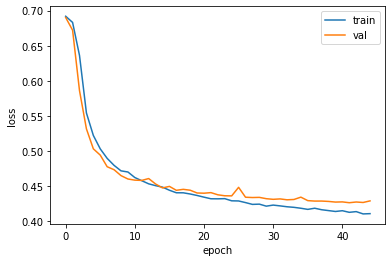

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 과대적합을 제어하면서 손실을 최대한 낮춤

## GRU 구조

- Gated Recurrent Unit
- 이 셀은 LSTM을 간소화한 버전으로 생각 가능
  - LSTM처럼 셀 상태를 계산하지 않고 은닉 상태 하나만 포함

- GRU 셀에는 은닉 상태와 입력에 가중치를 곱하고 절편을 더하는 작은 셀이 3개 들어 있음
  - 2개는 시그모이드 활성화 함수를 사용하고 하나는 tanh 활성화 함수를 사용
- 여기에서도 은닉 상태화 입력에 곱해지는 가중치를 합쳐서 나타냄

- 맨 왼쪽에서 $w_{z}$를 사용하는 셀의 출력이 은닉 상테에 바로 곱해져 삭제 게이트 역할을 수행
- 이와 똑같은 출력을 1에서 뺀 다음에 가장 오른쪽 $w_{g}$를 사요하는 셀의 출력에 곱함
  - 이는 입력되는 정보를 제어하는 역할을 수행
- 가운데 $w_{r}$을 사용하는 셀에서 출력된 값은 $w_{g}$셀이 사용할 은닉 상태의 정보를 제어

- GRU 셀은 LSTM보다 가중치가 적기 때문에 계산량이 적지만 LSTM 못지않은 좋은 성능을 내는 것으로 알려짐

## GRU 신경망 훈련하기

In [22]:
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(500, 16, input_length=100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

In [24]:
model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


- GRU 층의 모델 파라미터 개수를 계산
  - GRU 셀에는 3개의 작은 셀이 존재
- 작은 셀에는 입력과 은닉 상태에 곱하는 가중치와 절편이 존재
- 입력에 곱하는 가중치는 $16 \times 8 =128$이고 은닉상태에 곱하는 가중치는 $8 \times 8 =64$개
- 절편은 뉴런마다 하나씩이므로 8개
- 모두 더하면 $128 + 64+8=200$개
  - 이런 작은 셀이 3개이므로 모두 600개의 모델 파라미터가 필요

- But) summary() 메서드의 출력은 624개

- GRU 셀의 초기 버전 계산
  - 은닉 상태가 먼저 가중치와 곱해진 다음 가운데 셀의 출력과 곱해짐
- 이전에는 입력과 은닉 상태에 곱해지는 가중치를 $w_{g}$로 별도로 표기했지만, 이번에는 $w_{x}$와 $w_{h}$로 나눔
- 이렇게 나누어 계산하면 은닉 상태에 곱해지는 가중치 외에 절편이 별도로 필요
  - 따라서, 작은 셀마다 하나씩 절편이 추가되고 8개의 뉴런이 있으므로 총 24개의 모델 파라미터가 더해짐
  - GRU 층의 총 모델 파라미터 개수는 624개가 됨

In [25]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss = 'binary_crossentropy',
              metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.h5',
                                                 save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model4.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 14s 39ms/step - loss: 0.6926 - accuracy: 0.5252 - val_loss: 0.6921 - val_accuracy: 0.5400
Epoch 2/100
313/313 [==============================] - 12s 37ms/step - loss: 0.6911 - accuracy: 0.5662 - val_loss: 0.6904 - val_accuracy: 0.5648
Epoch 3/100
313/313 [==============================] - 14s 46ms/step - loss: 0.6886 - accuracy: 0.5810 - val_loss: 0.6876 - val_accuracy: 0.5776
Epoch 4/100
313/313 [==============================] - 13s 40ms/step - loss: 0.6845 - accuracy: 0.5996 - val_loss: 0.6831 - val_accuracy: 0.5930
Epoch 5/100
313/313 [==============================] - 13s 41ms/step - loss: 0.6782 - accuracy: 0.6112 - val_loss: 0.6763 - val_accuracy: 0.6054
Epoch 6/100
313/313 [==============================] - 12s 38ms/step - loss: 0.6686 - accuracy: 0.6296 - val_loss: 0.6658 - val_accuracy: 0.6186
Epoch 7/100
313/313 [==============================] - 12s 39ms/step - loss: 0.6541 - accuracy: 0.6432 - val_loss: 0.6495 - val_ac

- LSTM과 비슷한 성능

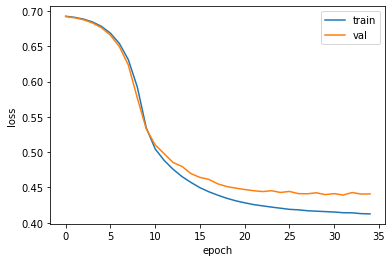

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 드롭아웃을 사용하지 않았기 때문에 이전보다 훈련 손실과 검증 손실 사이에 차이가 있지만 훈련 과정이 잘 수렴되고 있는 것을 확인 가능

## 마무리

### 키워드로 끝내는 핵심 포인트

- LSTM : 셀은 타임스텝이 긴 데이터를 효과적으로 학습하기 위해 고안된 순환층
  - 입력 게이트, 삭제 게이트, 출력 게이트 역할을 하는 작은 셀이 포함되어 있음
- LSTM 셀은 은닉 상태 외에 **셀 상태**를 출력.
  - 셀 상태는 다음 층으로 전달되지 않으며 현재 셀에서만 순환됨
- GRU 셀 : LSTM 셀의 간소화 버전으로 생각할 수 있지만 LSTM 셀에 못지않은 성능을 냄

### 핵심 패키지와 함수

> TensorFlow
- LSTM : LSTM 셀을 사용한 순환층 클래스
  - 첫 번째 매개변수 : 뉴런의 개수를 지정
  - dropout : 입력에 대한 드롭아웃 비율을 지정
  - return_sequences : 모든 타임스텝의 은닉 상태를 출력할 지 결정
    - 기본값 : False
- GRU : GRU 셀을 사용한 순환층 클래스
  - 첫 번째 매개변수 : 뉴런의 개수를 지정
  - dropout : 입력에 대한 드롭아웃 비율을 지정
  - return_sequences : 모든 타임스텝의 은닉 상태를 출력할 지 결정
    - 기본값 : False